# Title: What is the Myers–Briggs Type Indicator (MBTI) Associated with the musical features of a playlist?

## Tasks: (due date: April 7th, 11:59 pm)
* add explanations to visualization and a conclusion to the EDA - Roy
* read dataset from web - email the TA - CC
* performs the data analysis - Megan
* creates a visualization of the analysis - Josh

Link to the dataset: https://www.kaggle.com/datasets/xtrnglc/spotify-mbti-playlists

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
library(rsample)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Introduction:
The Myers-Briggs Type Indicator (MBTI), based on the theory of psychological types described by C. G. Jung, describes personality across four axes with a total of sixteen distinct combinations (The Myers & Briggs Foundation). Research shows that musical taste is related to personality, but little evidence demonstrates how predictable musical features are. 

This study attempts to classify the MBTI associated with the given musical characteristics of a playlist using a k-nearest neighbor classification model. The dataset, titled "Spotify MBTI Playlists", contains aggregated information on eleven different musical features for a Spotify playlist on each row.

In [2]:
# Read the dataset
spotify_mbti <- read_csv("combined_mbti_df.csv") |>
    mutate(mbti = as_factor(mbti))
spotify_mbti

Rows: 4081 Columns: 46
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): mbti, function_pair
dbl (44): danceability_mean, danceability_stdev, energy_mean, energy_stdev, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mbti,function_pair,danceability_mean,danceability_stdev,energy_mean,energy_stdev,loudness_mean,loudness_stdev,mode_mean,mode_stdev,⋯,Aminor_count,AMajor_count,A#/Bbminor_count,BMajor_count,Dminor_count,D#_Ebminor_count,Gminor_count,A#/BbMajor_count,F#/GbMajor_count,Bminor_count
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
INFP,NF,0.5578409,0.1550106,0.5533250,0.2251780,-8.352591,3.273317,0.6590909,0.4794950,⋯,2,2,1,4,0,0,0,0,0,0
INFP,NF,0.5876364,0.1356443,0.5562727,0.1916420,-8.215697,3.356867,0.6363636,0.4885042,⋯,1,2,1,4,1,1,1,1,0,0
INFP,NF,0.6770000,0.1280094,0.8512800,0.1283365,-5.046100,2.180554,0.5800000,0.4985694,⋯,0,1,1,3,1,0,0,1,2,9
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ESTJ,SJ,0.5853125,0.1819083,0.6943750,0.1736364,-5.307063,1.531874,0.5625000,0.5123475,⋯,1,1,2,0,1,0,0,0,0,1
ESTJ,SJ,0.6360400,0.1523822,0.6524200,0.1760419,-6.553020,2.813042,0.5400000,0.5034574,⋯,2,0,3,1,0,1,2,2,1,3
ESTJ,SJ,0.6407333,0.1452048,0.6783333,0.1824823,-5.763733,2.075266,0.5555556,0.5025189,⋯,2,0,4,1,2,0,3,1,2,2


In [3]:
# Clean the dataset by combining all majors and minors into two columns and removing NA rows
spotify_mbti_cleaned <- spotify_mbti |>
    select(-function_pair) |>
    mutate(major_count = CMajor_count + `C#/DbMajor_count` + DMajor_count +
           `D#_EbMajor_count` + EMajor_count + FMajor_count + GMajor_count +
           `G#/AbMajor_count` + AMajor_count + BMajor_count + `A#/BbMajor_count` +
           `F#/GbMajor_count`,
           minor_count = Cminor_count + `C#/Dbminor_count` + Eminor_count +
          Fminor_count + `F#/Gbminor_count` + `G#/Abminor_count` + 
          Aminor_count + `A#/Bbminor_count` + Dminor_count + `D#_Ebminor_count` +
          Gminor_count + Bminor_count) |>
    select(mbti:instrumentalness_stdev, major_count, minor_count) |>
    filter(!is.na(minor_count))

spotify_mbti_cleaned

mbti,danceability_mean,danceability_stdev,energy_mean,energy_stdev,loudness_mean,loudness_stdev,mode_mean,mode_stdev,speechiness_mean,⋯,liveness_mean,liveness_stdev,valence_mean,valence_stdev,tempo_mean,tempo_stdev,instrumentalness_mean,instrumentalness_stdev,major_count,minor_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
INFP,0.5578409,0.1550106,0.5533250,0.2251780,-8.352591,3.273317,0.6590909,0.4794950,0.06734091,⋯,0.1634023,0.0862659,0.4488841,0.2217635,120.9548,32.16578,0.01997099,0.08180459,29,15
INFP,0.5876364,0.1356443,0.5562727,0.1916420,-8.215697,3.356867,0.6363636,0.4885042,0.07427273,⋯,0.1545424,0.1124957,0.4476030,0.2160687,131.8712,33.21601,0.06104086,0.17755873,21,12
INFP,0.6770000,0.1280094,0.8512800,0.1283365,-5.046100,2.180554,0.5800000,0.4985694,0.27254600,⋯,0.2645200,0.2080966,0.2650300,0.1705175,128.2060,26.92719,0.25035756,0.33180466,29,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ESTJ,0.5853125,0.1819083,0.6943750,0.1736364,-5.307063,1.531874,0.5625000,0.5123475,0.09024375,⋯,0.1578000,0.1065317,0.5220625,0.2437776,122.6099,33.19806,0.0009960725,0.0029272391,9,7
ESTJ,0.6360400,0.1523822,0.6524200,0.1760419,-6.553020,2.813042,0.5400000,0.5034574,0.09537600,⋯,0.1564140,0.1230124,0.5587180,0.2778599,125.0429,29.28428,0.0389386528,0.1495546238,27,23
ESTJ,0.6407333,0.1452048,0.6783333,0.1824823,-5.763733,2.075266,0.5555556,0.5025189,0.10697778,⋯,0.1925044,0.1268794,0.5557111,0.2316916,123.6504,27.03963,0.0001314116,0.0005088235,25,20


In [4]:
# Seed setting and data splitting
set.seed(1)

spotify_split <- initial_split(spotify_mbti_cleaned, prop = 0.75)  
spotify_mbti_train <- training(spotify_split)   
spotify_mbti_test <- testing(spotify_split)

### Summarize the data in tables

In [5]:
# report number of observations in each class
observation_count <- spotify_mbti_train |>
    group_by(mbti) |>
    summarize(count = n())
observation_count

mbti,count
<fct>,<int>
INFP,231
ENFP,225
INFJ,241
⋮,⋮
ESFJ,84
ISTJ,143
ESTJ,82


In [6]:
# report means of the predictor variables
means_table <- spotify_mbti_train |>
    summarize(across(danceability_mean:minor_count, mean, na.rm = TRUE))

glimpse(means_table)

Rows: 1
Columns: 22
$ danceability_mean      <dbl> 0.5937052
$ danceability_stdev     <dbl> 0.1372644
$ energy_mean            <dbl> 0.6351733
$ energy_stdev           <dbl> 0.1753721
$ loudness_mean          <dbl> -7.130696
$ loudness_stdev         <dbl> 2.869923
$ mode_mean              <dbl> 0.6026921
$ mode_stdev             <dbl> 0.4713741
$ speechiness_mean       <dbl> 0.0782699
$ speechiness_stdev      <dbl> 0.06497499
$ acousticness_mean      <dbl> 0.2505405
$ acousticness_stdev     <dbl> 0.2391013
$ liveness_mean          <dbl> 0.1808428
$ liveness_stdev         <dbl> 0.1309472
$ valence_mean           <dbl> 0.4752963
$ valence_stdev          <dbl> 0.2111479
$ tempo_mean             <dbl> 121.892
$ tempo_stdev            <dbl> 28.71042
$ instrumentalness_mean  <dbl> 0.07774629
$ instrumentalness_stdev <dbl> 0.1475589
$ major_count            <dbl> 24.80667
$ minor_count            <dbl> 16.30422


In [7]:
# report how many rows have missing data
na_rows <- spotify_mbti_train[!complete.cases(spotify_mbti_train), ]
na_rows
nrow(na_rows)

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


mbti,danceability_mean,danceability_stdev,energy_mean,energy_stdev,loudness_mean,loudness_stdev,mode_mean,mode_stdev,speechiness_mean,⋯,liveness_mean,liveness_stdev,valence_mean,valence_stdev,tempo_mean,tempo_stdev,instrumentalness_mean,instrumentalness_stdev,major_count,minor_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


[1] 0

### Visualize the data with plots

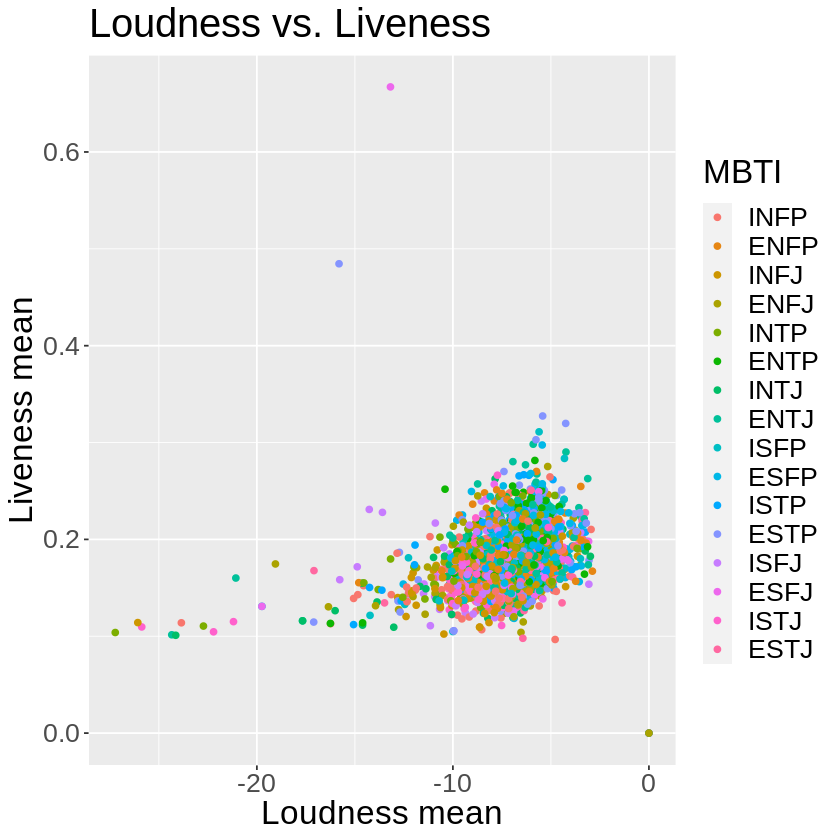

In [8]:
# Plot loudness vs liveness
loudness_liveness_mean <- spotify_mbti_train |>  
    ggplot(aes(x = loudness_mean, 
               y = liveness_mean, 
               colour = mbti)) +
    geom_point() +
    labs(x = "Loudness mean",
             y = "Liveness mean",
            colour = 'MBTI') +
    ggtitle("Loudness vs. Liveness") +
    theme(text = element_text(size = 20))
loudness_liveness_mean

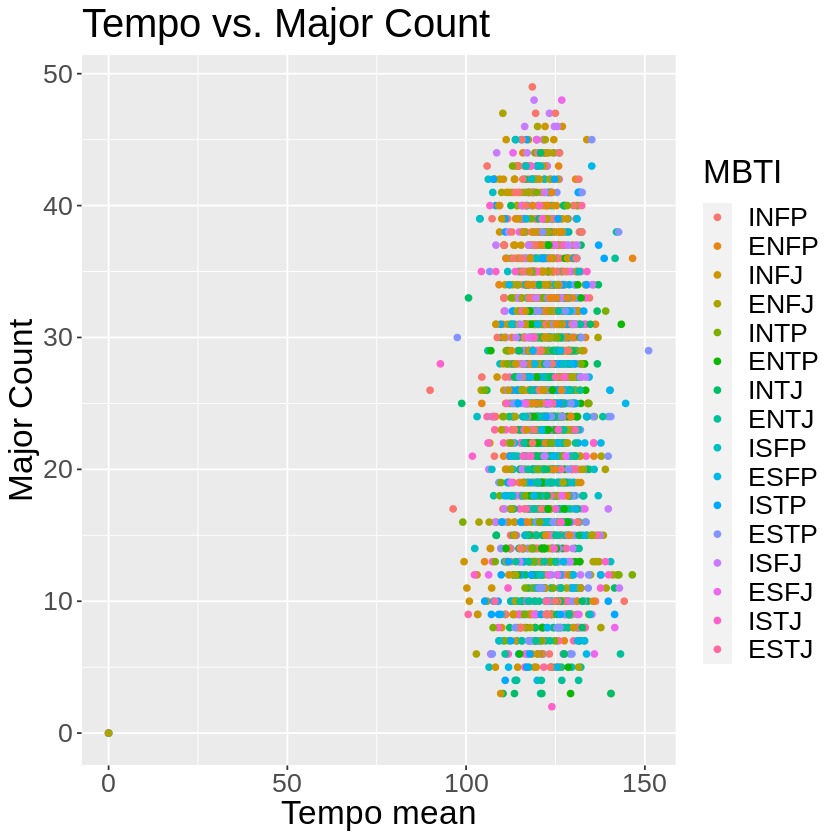

In [9]:
# Plot tempo vs major count
tempo_major_count <- spotify_mbti_train |>  
    ggplot(aes(x = tempo_mean, 
               y = major_count, 
               colour = mbti)) +
    geom_point() +
    labs(x = "Tempo mean",
             y = "Major Count",
            colour = 'MBTI') +
    ggtitle("Tempo vs. Major Count") +
    theme(text = element_text(size = 20))
tempo_major_count

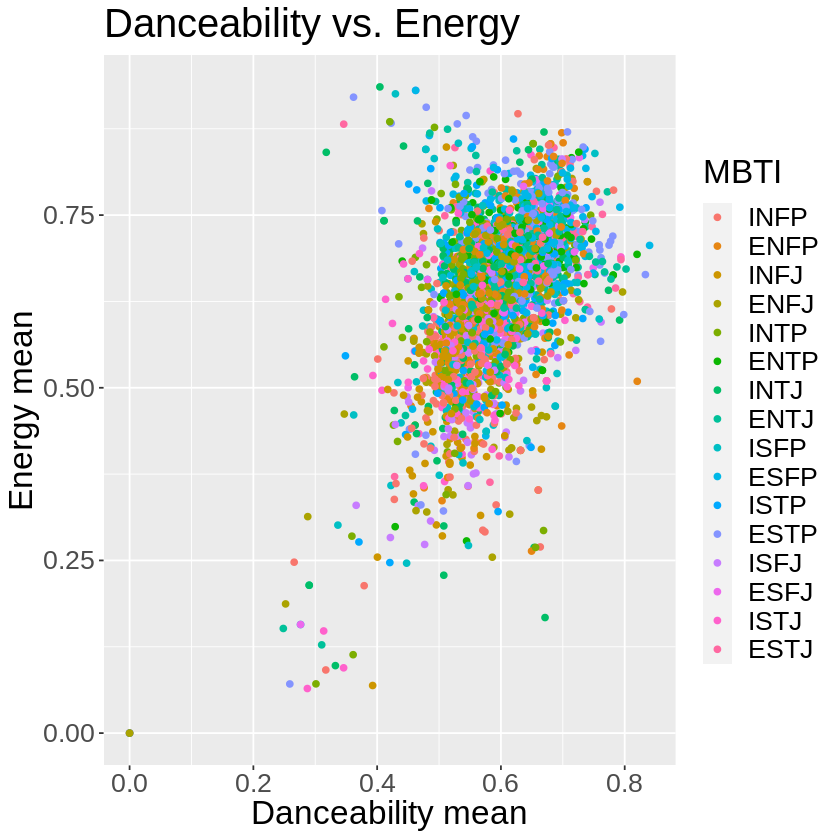

In [10]:
# Plot danceability vs energy
danceability_energy_mean <- spotify_mbti_train |>  
    ggplot(aes(x = danceability_mean, 
               y = energy_mean, 
               colour = mbti)) +
    geom_point() +
    labs(x = "Danceability mean",
             y = "Energy mean",
            colour = 'MBTI') +
    ggtitle("Danceability vs. Energy") +
    theme(text = element_text(size = 20))
danceability_energy_mean

## Methods & Results:

INSTRUCTIONS:
describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
your report should include code which:
* loads data from the original source on the web 
* wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
* performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
* creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
* performs the data analysis
* creates a visualization of the analysis 
* note: all tables and figure should have a figure/table number and a legend


We will conduct our data analysis by using the K-nearest neighbor classification to predict MBTI from the musical features of Spotify playlists. All variables will be used except for function_pair as it represents the same information as mbti. To decrease the number of predictable variables, we will need to put all the majors into one column and all the minors into another. Furthermore, cross-validation will be used to tune the number of neighbors to optimize the model's performance.

One way we will visualize the results is by visualizing the confusion matrix as a bar plot with the number of correctly identified MBTI types plot against the number of incorrectly identified MBTI types.

## Discussion
* summarize what you found
* discuss whether this is what you expected to find?
* discuss what impact could such findings have?
* discuss what future questions could this lead to?

## References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.

* https://www.kaggle.com/datasets/xtrnglc/spotify-mbti-playlists
* https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/
* https://www.verywellmind.com/music-and-personality-2795424